In [65]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
IMG_SIZE = 256
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
base_seg_path = "/kaggle/input/brisc2025/brisc2025/segmentation_task"
base_cls_path = "/kaggle/input/brisc2025/brisc2025/classification_task"
CHECKPOINT_PATH_SEG = "/kaggle/working/seg_checkpoint.pth"
CHECKPOINT_PATH_CLS = "/kaggle/working/cls_checkpoint.pth"
CHECKPOINT_PATH_JOINT = "/kaggle/working/joint_checkpoint.pth"
BEST_MODEL_PATH_SEG = "/kaggle/working/best_seg_model.pth"
BEST_MODEL_PATH_CLS = "/kaggle/working/best_cls_model.pth"
BEST_MODEL_PATH_JOINT = "/kaggle/working/best_joint_model.pth"

In [3]:
class BinaryMorphology:
    def __init__(self, operation='dilation', kernel_size=3, iterations=1):
        self.operation = operation
        self.kernel_size = kernel_size
        self.iterations = iterations
        self.kernel = np.ones((kernel_size, kernel_size), dtype=np.float32)

    def __call__(self, mask):
        mask_np = mask.numpy().squeeze()  
        if self.operation == 'dilation':
            mask_np = ndimage.binary_dilation(mask_np, structure=self.kernel, iterations=self.iterations).astype(np.float32)
        elif self.operation == 'erosion':
            mask_np = ndimage.binary_erosion(mask_np, structure=self.kernel, iterations=self.iterations).astype(np.float32)
        return torch.tensor(mask_np, dtype=torch.float32).unsqueeze(0)  

# Pipeline
image_transform = T.Compose([
    T.ToTensor(),  
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.GaussianBlur(kernel_size=3, sigma=1.0),
    T.Normalize(mean=[0.5], std=[0.5])  
])

mask_transform = T.Compose([
    T.ToTensor(),
    T.Resize((IMG_SIZE, IMG_SIZE), interpolation=T.InterpolationMode.NEAREST), 
    BinaryMorphology(operation='dilation', kernel_size=3, iterations=1),  
    lambda x: (x > 0).float() 
])

In [66]:
def dice_metric(predicted, target, threshold=0.5, smooth=1e-8):
    probs = torch.sigmoid(predicted)
    preds = (probs > threshold).float()
    target = target.float()
    intersection = (preds * target).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean() 

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-8):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predicted, target):
        probs = torch.sigmoid(predicted)
        preds = probs.view(-1)
        target = target.view(-1)
        intersection = (preds * target).sum()
        union = preds.sum() + target.sum()
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice

def save_checkpoint(state, filename="/kaggle/working/checkpoint.pth"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint_path, model):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    state_dict = checkpoint["state_dict"]
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            new_state_dict[k[7:]] = v 
        else:
            new_state_dict[k] = v
    model.load_state_dict(new_state_dict)

In [67]:
def miou_metric(predicted, target, threshold=0.5, smooth=1e-8):
    probs = torch.sigmoid(predicted)
    preds = (probs > threshold).float()
    target = target.float()
    intersection = (preds * target).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    iou_foreground = (intersection + smooth) / (union + smooth)
    # Background IoU
    preds_bg = 1 - preds
    target_bg = 1 - target
    intersection_bg = (preds_bg * target_bg).sum(dim=(2, 3))
    union_bg = preds_bg.sum(dim=(2, 3)) + target_bg.sum(dim=(2, 3)) - intersection_bg
    iou_background = (intersection_bg + smooth) / (union_bg + smooth)
    miou = (iou_foreground + iou_background) / 2
    return miou.mean().item()

def pixel_accuracy(predicted, target, threshold=0.5):
    probs = torch.sigmoid(predicted)
    preds = (probs > threshold).float()
    target = target.float()
    correct = (preds == target).float().sum(dim=(2, 3))
    total = torch.tensor(target.shape[2] * target.shape[3], dtype=torch.float, device=target.device)
    return (correct / total).mean().item()

def precision_recall_f1(predicted, target, num_classes=4, average="macro"):

    probs = F.softmax(predicted, dim=1)
    _, preds = torch.max(probs, 1)

    
    preds = preds.detach().cpu().numpy()
    target = target.detach().cpu().numpy()

    precision = precision_score(target, preds, average=average, zero_division=0)
    recall    = recall_score(target, preds, average=average, zero_division=0)
    f1        = f1_score(target, preds, average=average, zero_division=0)

    return precision, recall, f1

In [68]:
class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, image_transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        img_names = sorted(os.listdir(img_dir))
        mask_names = set(os.listdir(mask_dir))
        self.img_names = [
            (img_name, img_name.replace('.jpg', '.png'))
            for img_name in img_names
            if img_name.replace('.jpg', '.png') in mask_names
        ]
        print(f"Found {len(self.img_names)} valid image-mask pairs")

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name, mask_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)
        img = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        if self.image_transform:
            img = self.image_transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        return img, mask

# class ClassificationDataset(Dataset):
#     def __init__(self, base_dir, transform=None):
#         self.transform = transform
#         self.classes = sorted(os.listdir(base_dir))
#         self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
#         self.samples = []
#         for cls_name in self.classes:
#             cls_dir = os.path.join(base_dir, cls_name)
#             if os.path.isdir(cls_dir):
#                 for img_name in os.listdir(cls_dir):
#                     self.samples.append((os.path.join(cls_dir, img_name), self.class_to_idx[cls_name]))
#         print(f"Found {len(self.samples)} images across {len(self.classes)} classes: {self.classes}")

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         img_path, label = self.samples[idx]
#         img = Image.open(img_path).convert("L")
#         if self.transform:
#             img = self.transform(img)
#         return img, label

In [81]:
class ClassificationDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.transform = transform
        self.classes = sorted(os.listdir(base_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}
        self.samples = []
        for cls_name in self.classes:
            cls_dir = os.path.join(base_dir, cls_name)
            if os.path.isdir(cls_dir):
                for img_name in os.listdir(cls_dir):
                    self.samples.append((os.path.join(cls_dir, img_name), cls_name))
        print(f"Found {len(self.samples)} images across {len(self.classes)} classes: {self.classes}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, cls_name = self.samples[idx]
        img = Image.open(img_path).convert("L")
        if self.transform:
            img = self.transform(img)
        return img, label

In [70]:
seg_train_dataset = SegmentationDataset(
    img_dir=os.path.join(base_seg_path, "train/images"),
    mask_dir=os.path.join(base_seg_path, "train/masks"),
    image_transform=image_transform,
    mask_transform=mask_transform
)

seg_val_dataset = SegmentationDataset(
    img_dir=os.path.join(base_seg_path, "test/images"),
    mask_dir=os.path.join(base_seg_path, "test/masks"),
    image_transform=image_transform,
    mask_transform=mask_transform
)

cls_train_dataset = ClassificationDataset(
    base_dir=os.path.join(base_cls_path, "train"),
    transform=image_transform
)

cls_val_dataset = ClassificationDataset(
    base_dir=os.path.join(base_cls_path, "test"),
    transform=image_transform
)

# DataLoaders
seg_train_dataloader = DataLoader(seg_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
seg_val_dataloader = DataLoader(seg_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
cls_train_dataloader = DataLoader(cls_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
cls_val_dataloader = DataLoader(cls_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Found 3933 valid image-mask pairs
Found 860 valid image-mask pairs
Found 5000 images across 4 classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Found 1000 images across 4 classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


In [71]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Encoder(nn.Module):
    def __init__(self, in_channels=1, channels=(64, 128, 256, 512)):
        super(Encoder, self).__init__()
        self.down = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        for channel in channels:
            self.down.append(DoubleConv(in_channels, channel))
            in_channels = channel

    def forward(self, x):
        residual_connections = []
        for down in self.down:
            x = down(x)
            residual_connections.append(x)
            x = self.pool(x)
        return x, residual_connections

# Decoder for Segmentation
class SegDecoder(nn.Module):
    def __init__(self, out_channels=1, channels=(512, 256, 128, 64)):
        super(SegDecoder, self).__init__()
        self.up_tp = nn.ModuleList()
        self.dc = DoubleConv(512, 1024)
        for channel in channels:
            self.up_tp.append(
                nn.ConvTranspose2d(channel * 2, channel, kernel_size=2, stride=2)
            )
            self.up_tp.append(DoubleConv(channel * 2, channel))
        self.final_conv = nn.Conv2d(channels[-1], out_channels, kernel_size=1)

    def forward(self, x):
        out, residual_connections = x
        residual_connections = residual_connections[::-1]
        out = self.dc(out)
        for i in range(0, len(self.up_tp), 2):
            out = self.up_tp[i](out)
            residual_connection = residual_connections[i // 2]
            if out.shape != residual_connection.shape:
                out = TF.resize(out, size=residual_connection.shape[2:])
            concat_residue = torch.cat((residual_connection, out), dim=1)
            out = self.up_tp[i + 1](concat_residue)
        return self.final_conv(out)

# Decoder for Classification
class ClsDecoder(nn.Module):
    def __init__(self, num_classes=4, channels=(512, 256, 128, 64)):
        super(ClsDecoder, self).__init__()
        self.up_tp = nn.ModuleList()
        self.dc = DoubleConv(512, 1024)
        for channel in channels:
            self.up_tp.append(
                nn.ConvTranspose2d(1024 if channel == 512 else channel * 2, channel, kernel_size=2, stride=2)
            )
            self.up_tp.append(DoubleConv(channel * 2, channel))
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        out, residual_connections = x
        residual_connections = residual_connections[::-1]
        out = self.dc(out)
        for i in range(0, len(self.up_tp), 2):
            out = self.up_tp[i](out)
            residual_connection = residual_connections[i // 2]
            if out.shape != residual_connection.shape:
                out = TF.resize(out, size=residual_connection.shape[2:])
            concat_residue = torch.cat((residual_connection, out), dim=1)
            out = self.up_tp[i + 1](concat_residue)
        return self.classifier(out)

In [72]:
class SegmentationUNet(nn.Module):
    def __init__(self):
        super(SegmentationUNet, self).__init__()
        self.encoder = Encoder(in_channels=1)
        self.decoder = SegDecoder(out_channels=1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class ClassificationUNet(nn.Module):
    def __init__(self):
        super(ClassificationUNet, self).__init__()
        self.encoder = Encoder(in_channels=1)
        self.decoder = ClsDecoder(num_classes=4)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class JointUNet(nn.Module):
    def __init__(self):
        super(JointUNet, self).__init__()
        self.encoder = Encoder(in_channels=1)
        self.seg_decoder = SegDecoder(out_channels=1)
        self.cls_decoder = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        bottleneck, residual_connections = self.encoder(x)
        seg_output = self.seg_decoder((bottleneck, residual_connections))
        cls_output = self.cls_decoder(bottleneck)
        return seg_output, cls_output

In [ ]:
def train_model(
    model, 
    seg_dataloader, cls_dataloader, 
    seg_val_dataloader, cls_val_dataloader, 
    seg_criterion, cls_criterion, 
    optimizer, num_epochs, device, 
    model_type="joint", 
    checkpoint_path="/kaggle/working/checkpoint.pth",
    patience=5,          # <-- NEW
    min_delta=0.0        # <-- NEW (treat any >0 improvement as progress)
):
    class_to_idx = cls_train_dataset.class_to_idx if cls_dataloader else {}
    idx_to_class = cls_train_dataset.idx_to_class if cls_dataloader else {}

    best_dice = float("-inf")
    best_acc  = float("-inf")
    no_improve = 0  # <-- NEW

    for epoch in range(num_epochs):
        model.train()
        running_seg_loss = 0.0
        running_cls_loss = 0.0
        cls_correct = 0
        cls_total = 0

        # -------------------- Train --------------------
        if model_type in ["seg", "joint"]:
            for images, masks in seg_dataloader:
                images, masks = images.to(device), masks.to(device)
                optimizer.zero_grad()
                outputs = model(images) if model_type == "seg" else model(images)[0]
                loss = seg_criterion(outputs, masks)
                loss.backward()
                optimizer.step()
                running_seg_loss += loss.item()

        if model_type in ["cls", "joint"]:
            for images, cls_names in cls_dataloader:
                images = images.to(device)
                labels = torch.tensor([class_to_idx[name] for name in cls_names], dtype=torch.long).to(device)
                optimizer.zero_grad()
                outputs = model(images) if model_type == "cls" else model(images)[1]
                loss = cls_criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_cls_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                cls_correct += (predicted == labels).sum().item()
                cls_total += labels.size(0)

        avg_seg_loss = running_seg_loss / len(seg_dataloader) if model_type in ["seg", "joint"] else 0
        avg_cls_loss = running_cls_loss / len(cls_dataloader) if model_type in ["cls", "joint"] else 0
        train_cls_acc = cls_correct / cls_total if (model_type in ["cls", "joint"] and cls_total > 0) else 0

        # -------------------- Validate --------------------
        model.eval()
        val_dice = 0.0
        val_miou = 0.0
        val_pixel_acc = 0.0
        val_cls_correct = 0
        val_cls_total = 0
        val_precision = 0.0
        val_recall = 0.0
        val_f1 = 0.0

        with torch.no_grad():
            if model_type in ["seg", "joint"]:
                for images, masks in seg_val_dataloader:
                    images, masks = images.to(device), masks.to(device)
                    outputs = model(images) if model_type == "seg" else model(images)[0]
                    val_dice += dice_metric(outputs, masks)
                    val_miou += miou_metric(outputs, masks)
                    val_pixel_acc += pixel_accuracy(outputs, masks)

            if model_type in ["cls", "joint"]:
                for images, cls_names in cls_val_dataloader:
                    images = images.to(device)
                    labels = torch.tensor([class_to_idx[name] for name in cls_names], dtype=torch.long).to(device)
                    outputs = model(images) if model_type == "cls" else model(images)[1]
                    _, predicted = torch.max(outputs, 1)
                    val_cls_correct += (predicted == labels).sum().item()
                    val_cls_total += labels.size(0)
                    prec, rec, f1_score = precision_recall_f1(outputs, labels)
                    val_precision += prec
                    val_recall += rec
                    val_f1 += f1_score

        avg_val_dice = val_dice / len(seg_val_dataloader) if model_type in ["seg", "joint"] else 0
        avg_val_miou = val_miou / len(seg_val_dataloader) if model_type in ["seg", "joint"] else 0
        avg_val_pixel_acc = val_pixel_acc / len(seg_val_dataloader) if model_type in ["seg", "joint"] else 0

        val_cls_acc = (val_cls_correct / val_cls_total) if (model_type in ["cls", "joint"] and val_cls_total > 0) else 0
        avg_val_precision = val_precision / len(cls_val_dataloader) if (model_type in ["cls", "joint"] and len(cls_val_dataloader) > 0) else 0
        avg_val_recall    = val_recall    / len(cls_val_dataloader) if (model_type in ["cls", "joint"] and len(cls_val_dataloader) > 0) else 0
        avg_val_f1        = val_f1        / len(cls_val_dataloader) if (model_type in ["cls", "joint"] and len(cls_val_dataloader) > 0) else 0

        # --------- Print metrics ----------
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Seg Loss: {avg_seg_loss:.4f}, Cls Loss: {avg_cls_loss:.4f}, "
              f"Train Cls Acc: {train_cls_acc:.4f}, "
              f"Val Dice: {avg_val_dice:.4f}, Val mIoU: {avg_val_miou:.4f}, Val Pixel Acc: {avg_val_pixel_acc:.4f}, "
              f"Val Cls Acc: {val_cls_acc:.4f}, Val Precision: {avg_val_precision:.4f}, "
              f"Val Recall: {avg_val_recall:.4f}, Val F1: {avg_val_f1:.4f}")

        # --------- Save checkpoint ----------
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        save_checkpoint(checkpoint, checkpoint_path)

        # --------- Best model + early stopping logic ----------
        improved = False

        if model_type in ["seg", "joint"] and (avg_val_dice > best_dice + min_delta):
            best_dice = avg_val_dice
            torch.save(model.state_dict(), BEST_MODEL_PATH_SEG if model_type == "seg" else BEST_MODEL_PATH_JOINT)
            print(f"=> Saved best {model_type} (seg) model")
            improved = True

        if model_type in ["cls", "joint"] and (val_cls_acc > best_acc + min_delta):
            best_acc = val_cls_acc
            torch.save(model.state_dict(), BEST_MODEL_PATH_CLS if model_type == "cls" else BEST_MODEL_PATH_JOINT)
            print(f"=> Saved best {model_type} (cls) model")
            improved = True

        if improved:
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping triggered (patience={patience}). "
                      f"No improvement for {patience} consecutive epochs.")
                break


def visualize_predictions(model, dataloader, model_type, device, n_images=5):

    idx_to_class = cls_val_dataset.idx_to_class if model_type in ["cls", "joint"] else {}
    model.eval()

    def _plot_img(ax, t):
        # t: [C,H,W] or [H,W]
        if t.ndim == 3 and t.shape[0] == 3:
            ax.imshow(t.permute(1, 2, 0).cpu().numpy())
        else:
            ax.imshow(t.squeeze().cpu().numpy(), cmap="gray")
        ax.axis("off")

    with torch.no_grad():
        if model_type == "seg":
            images, masks = next(iter(dataloader))
            images, masks = images.to(device), masks.to(device)
            logits = model(images)
            preds = (torch.sigmoid(logits) > 0.5).float()

            k = min(n_images, images.size(0))
            idxs = torch.randperm(images.size(0))[:k]

            fig, axes = plt.subplots(k, 3, figsize=(12, 4*k))
            if k == 1: axes = axes.reshape(1, 3)
            for row, i in enumerate(idxs):
                _plot_img(axes[row, 0], images[i].cpu())
                axes[row, 0].set_title("Input")
                _plot_img(axes[row, 1], masks[i].cpu())
                axes[row, 1].set_title("Ground Truth")
                _plot_img(axes[row, 2], preds[i].cpu())
                axes[row, 2].set_title("Prediction")
            plt.tight_layout()
            plt.show()

        elif model_type == "cls":
            images, cls_names = next(iter(dataloader))
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            k = min(n_images, images.size(0))
            idxs = torch.randperm(images.size(0))[:k]

            fig, axes = plt.subplots(1, k, figsize=(4*k, 4))
            if k == 1: axes = [axes]
            for col, i in enumerate(idxs):
                pred_name = idx_to_class.get(predicted[i].item(), str(predicted[i].item()))
                true_name = cls_names[i]
                _plot_img(axes[col], images[i].cpu())
                axes[col].set_title(f"True: {true_name}\nPred: {pred_name}")
            plt.tight_layout()
            plt.show()

        else:  # joint
            # For joint, we’ll take the seg val loader batch for masks, and run the joint model
            images, masks = next(iter(seg_val_dataloader))
            images, masks = images.to(device), masks.to(device)
            seg_logits, cls_logits = model(images)
            seg_preds = (torch.sigmoid(seg_logits) > 0.5).float()
            _, cls_pred = torch.max(cls_logits, 1)

            k = min(n_images, images.size(0))
            idxs = torch.randperm(images.size(0))[:k]

            fig, axes = plt.subplots(k, 3, figsize=(12, 4*k))
            if k == 1: axes = axes.reshape(1, 3)
            for row, i in enumerate(idxs):
                pred_name = idx_to_class.get(cls_pred[i].item(), str(cls_pred[i].item()))
                _plot_img(axes[row, 0], images[i].cpu()); axes[row, 0].set_title("Input")
                _plot_img(axes[row, 1], masks[i].cpu());  axes[row, 1].set_title("Ground Truth Mask")
                _plot_img(axes[row, 2], seg_preds[i].cpu()); axes[row, 2].set_title(f"Pred Mask\n(Cls: {pred_name})")
            plt.tight_layout()
            plt.show()


In [74]:
# Initialize and Train Models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seg_criterion = DiceLoss()
cls_criterion = nn.CrossEntropyLoss()

Using 2 GPUs for Segmentation Model
Training Segmentation Model
Epoch [1/30], Seg Loss: 0.7720, Cls Loss: 0.0000, Train Cls Acc: 0.0000, Val Dice: 0.2994, Val mIoU: 0.5442, Val Pixel Acc: 0.8998, Val Cls Acc: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
=> Saving checkpoint
=> Saved best seg (seg) model
Epoch [2/30], Seg Loss: 0.3896, Cls Loss: 0.0000, Train Cls Acc: 0.0000, Val Dice: 0.5934, Val mIoU: 0.7455, Val Pixel Acc: 0.9864, Val Cls Acc: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
=> Saving checkpoint
=> Saved best seg (seg) model
Epoch [3/30], Seg Loss: 0.2980, Cls Loss: 0.0000, Train Cls Acc: 0.0000, Val Dice: 0.6090, Val mIoU: 0.7422, Val Pixel Acc: 0.9792, Val Cls Acc: 0.0000, Val Precision: 0.0000, Val Recall: 0.0000, Val F1: 0.0000
=> Saving checkpoint
=> Saved best seg (seg) model
Epoch [4/30], Seg Loss: 0.2712, Cls Loss: 0.0000, Train Cls Acc: 0.0000, Val Dice: 0.6424, Val mIoU: 0.7729, Val Pixel Acc: 0.9874, Val Cls Acc: 0.000

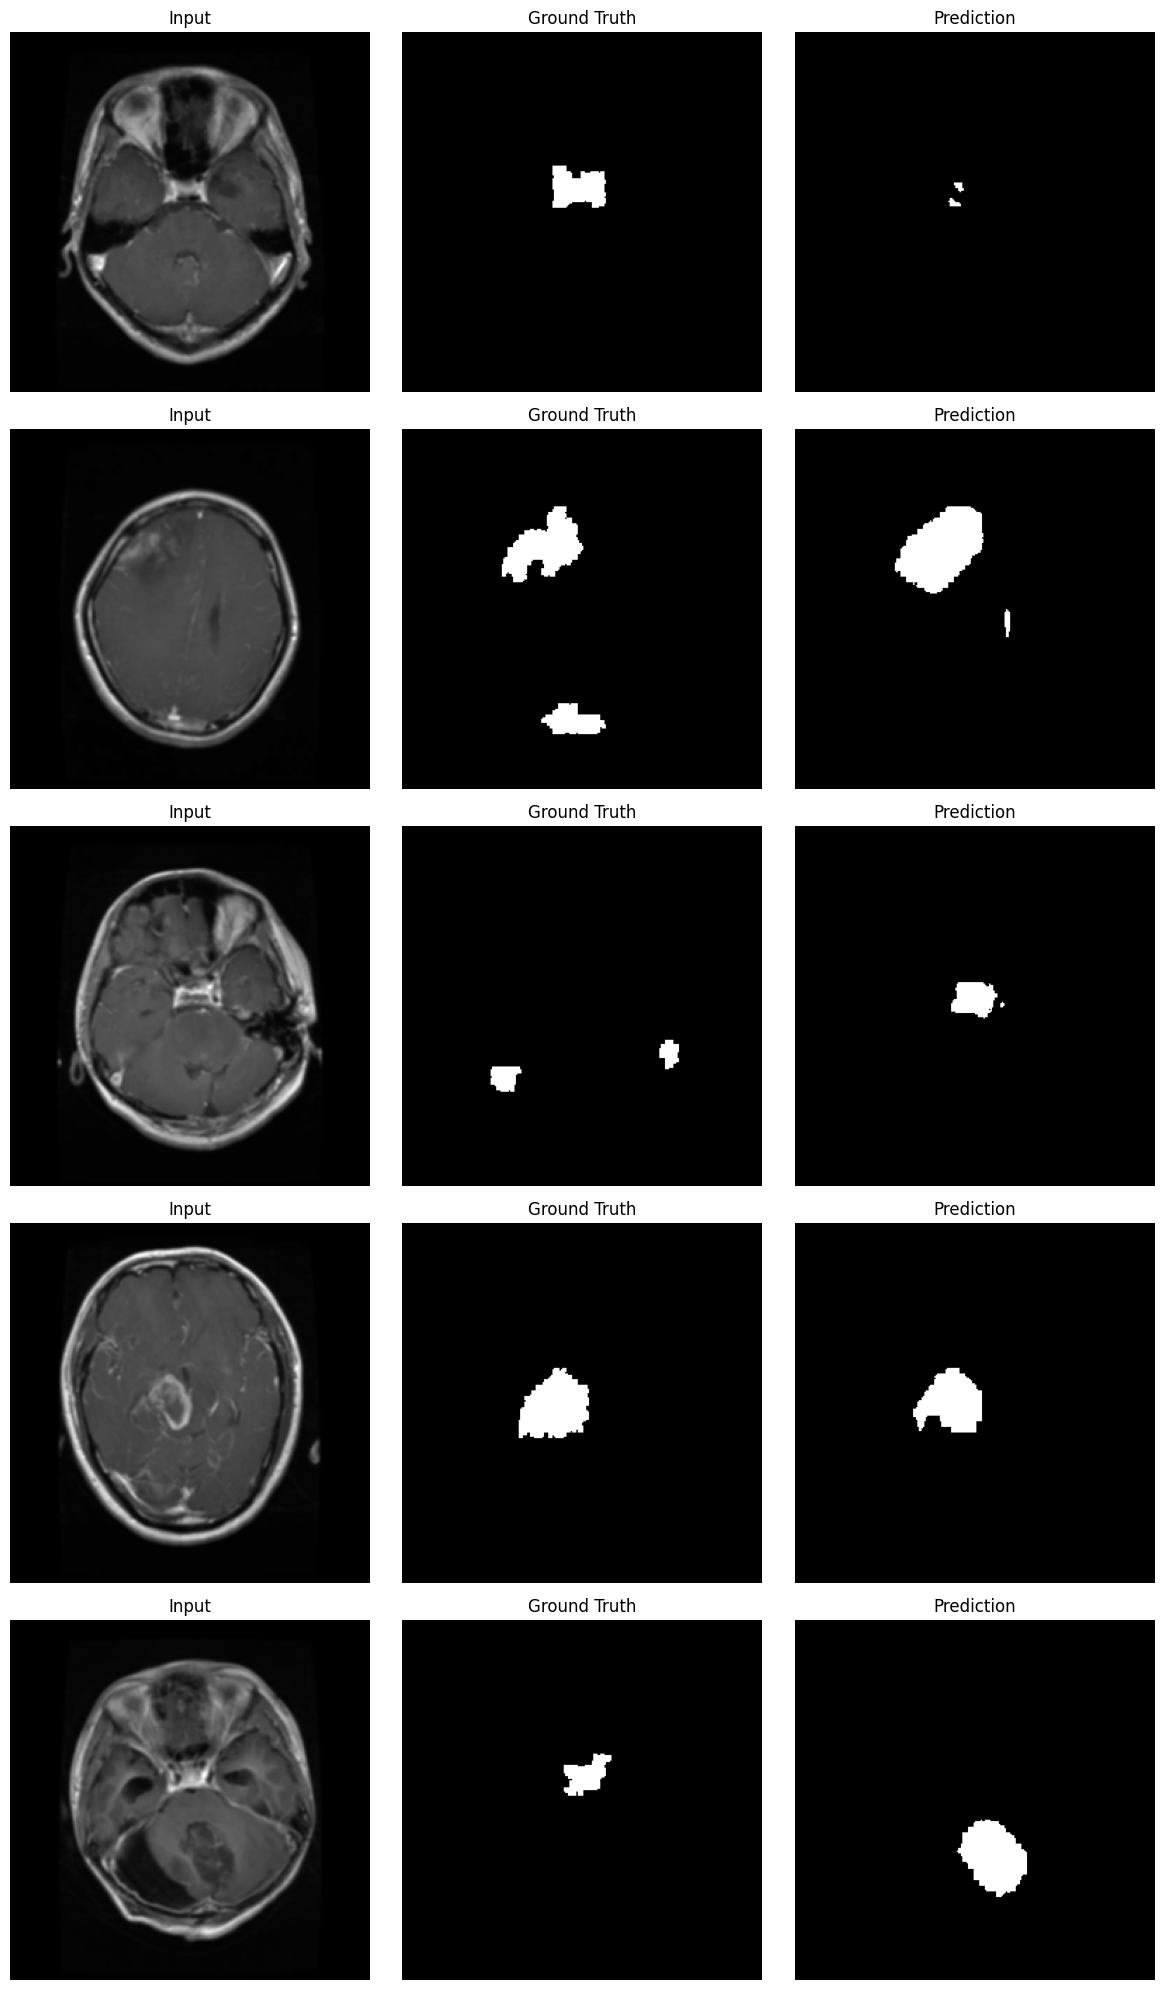

In [15]:
# Segmentation Model
seg_model = SegmentationUNet().to(device)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for Segmentation Model")
    seg_model = nn.DataParallel(seg_model)
seg_optimizer = optim.Adam(seg_model.parameters(), lr=LEARNING_RATE)
if os.path.exists(CHECKPOINT_PATH_SEG):
    load_checkpoint(CHECKPOINT_PATH_SEG, seg_model)
print("Training Segmentation Model")
train_model(
    seg_model, seg_train_dataloader, None,
    seg_val_dataloader, None,
    seg_criterion, None, seg_optimizer,
    NUM_EPOCHS, device,
    model_type="seg",
    checkpoint_path=CHECKPOINT_PATH_SEG,
    patience=5           
)
print("Visualizing Segmentation Model")
visualize_predictions(seg_model, seg_val_dataloader, "seg", device, n_images=5)  

In [28]:
import numpy as np

def segmentation_report(model, dataloader, device):
    model.eval()
    dices, mious, accs = [], [], []
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]

            dice = dice_metric(outputs, masks)
            miou = miou_metric(outputs, masks)
            acc  = pixel_accuracy(outputs, masks)

            if isinstance(dice, torch.Tensor):
                dice = dice.detach().cpu().item()
            if isinstance(miou, torch.Tensor):
                miou = miou.detach().cpu().item()
            if isinstance(acc, torch.Tensor):
                acc = acc.detach().cpu().item()

            dices.append(dice)
            mious.append(miou)
            accs.append(acc)

    print("\n--- Segmentation Report ---")
    print(f"Dice Coefficient: {np.mean(dices):.4f}")
    print(f"Mean IoU:         {np.mean(mious):.4f}")
    print(f"Pixel Accuracy:   {np.mean(accs):.4f}")
segmentation_report(seg_model, seg_val_dataloader, device)


--- Segmentation Report ---
Dice Coefficient: 0.7867
Mean IoU:         0.8490
Pixel Accuracy:   0.9916


Using 2 GPUs for Classification Model
Training Classification Model
Epoch [1/30], Seg Loss: 0.0000, Cls Loss: 0.9259, Train Cls Acc: 0.6342, Val Dice: 0.0000, Val mIoU: 0.0000, Val Pixel Acc: 0.0000, Val Cls Acc: 0.4920, Val Precision: 0.3358, Val Recall: 0.1844, Val F1: 0.2218
=> Saving checkpoint
=> Saved best cls (cls) model
Epoch [2/30], Seg Loss: 0.0000, Cls Loss: 0.6815, Train Cls Acc: 0.7362, Val Dice: 0.0000, Val mIoU: 0.0000, Val Pixel Acc: 0.0000, Val Cls Acc: 0.6010, Val Precision: 0.4246, Val Recall: 0.3131, Val F1: 0.3387
=> Saving checkpoint
=> Saved best cls (cls) model
Epoch [3/30], Seg Loss: 0.0000, Cls Loss: 0.6087, Train Cls Acc: 0.7712, Val Dice: 0.0000, Val mIoU: 0.0000, Val Pixel Acc: 0.0000, Val Cls Acc: 0.7480, Val Precision: 0.3729, Val Recall: 0.3037, Val F1: 0.3251
=> Saving checkpoint
=> Saved best cls (cls) model
Epoch [4/30], Seg Loss: 0.0000, Cls Loss: 0.5671, Train Cls Acc: 0.7948, Val Dice: 0.0000, Val mIoU: 0.0000, Val Pixel Acc: 0.0000, Val Cls Acc: 0

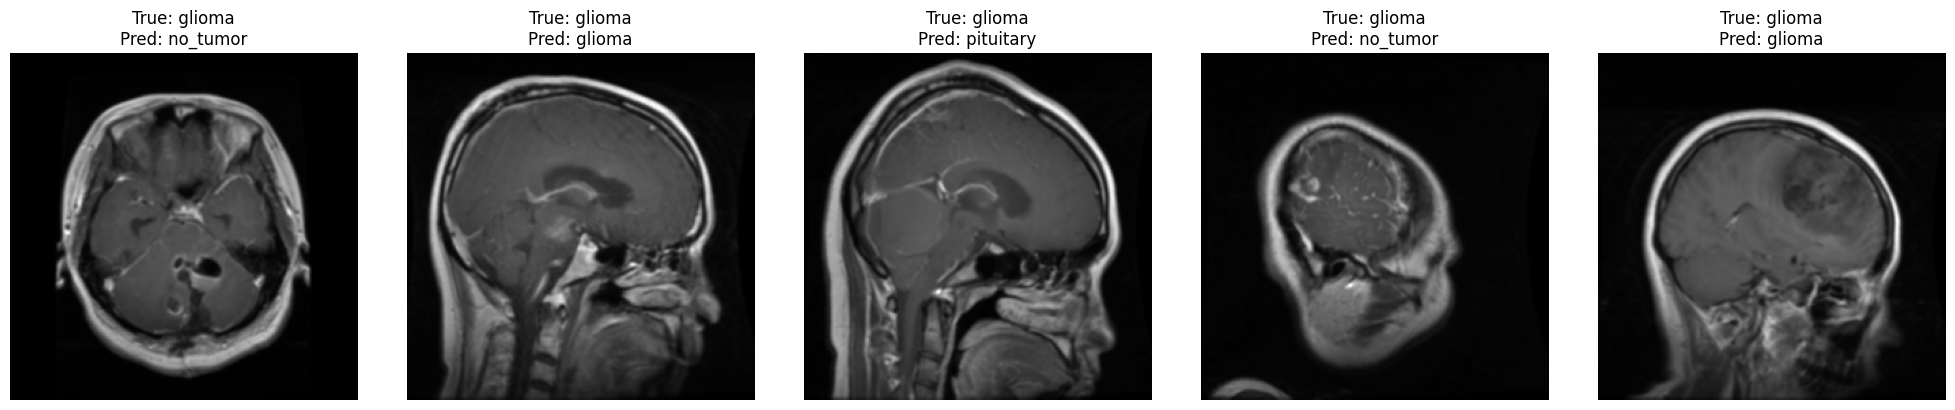

In [ ]:
# Classification Model
cls_model = ClassificationUNet().to(device)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for Classification Model")
    cls_model = nn.DataParallel(cls_model)
cls_optimizer = optim.Adam(cls_model.parameters(), lr=LEARNING_RATE)
if os.path.exists(CHECKPOINT_PATH_CLS):
    load_checkpoint(CHECKPOINT_PATH_CLS, cls_model)
print("Training Classification Model")
train_model(
    cls_model, None, cls_train_dataloader,
    None, cls_val_dataloader,
    None, cls_criterion, cls_optimizer,
    NUM_EPOCHS, device,
    model_type="cls",
    checkpoint_path=CHECKPOINT_PATH_CLS,
    patience=5           
)
print("Visualizing Classification Model")
visualize_predictions(cls_model, cls_val_dataloader, "cls", device, n_images=5)  

Classification Report:

              precision    recall  f1-score   support

      glioma       1.00      0.27      0.43       254
  meningioma       0.87      0.58      0.69       306
    no_tumor       0.33      1.00      0.50       140
   pituitary       0.90      0.92      0.91       300

    accuracy                           0.66      1000
   macro avg       0.77      0.69      0.63      1000
weighted avg       0.84      0.66      0.66      1000

Overall Accuracy: 0.6610
Confusion Matrix:
 [[ 69  21 146  18]
 [  0 176 116  14]
 [  0   0 140   0]
 [  0   5  19 276]]


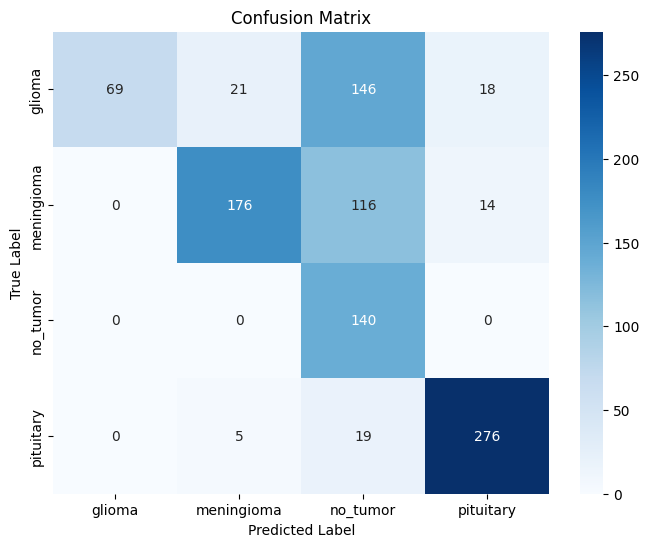

In [84]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_classification_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    idx_to_class = cls_val_dataset.idx_to_class

    with torch.no_grad():
        for images, cls_names in dataloader:
            images = images.to(device)
            labels = torch.tensor([cls_val_dataset.class_to_idx[name] for name in cls_names], dtype=torch.long).to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=[idx_to_class[i] for i in range(len(idx_to_class))], zero_division=0)
    print("Classification Report:\n")
    print(report)

    # Overall metrics
    overall_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Overall Accuracy: {overall_acc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)

    # Optional: plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=[idx_to_class[i] for i in range(len(idx_to_class))],
                yticklabels=[idx_to_class[i] for i in range(len(idx_to_class))], cmap="Blues")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()


# Call the function
evaluate_classification_model(cls_model, cls_val_dataloader, device)


Using 2 GPUs for Joint Model
Training Joint Model
Epoch [1/30], Seg Loss: 0.8134, Cls Loss: 0.8986, Train Cls Acc: 0.6270, Val Dice: 0.1385, Val mIoU: 0.4944, Val Pixel Acc: 0.9055, Val Cls Acc: 0.4190, Val Precision: 0.3544, Val Recall: 0.1800, Val F1: 0.1996
=> Saving checkpoint
=> Saved best joint (seg) model
=> Saved best joint (cls) model
Epoch [2/30], Seg Loss: 0.4615, Cls Loss: 0.7105, Train Cls Acc: 0.7078, Val Dice: 0.0579, Val mIoU: 0.5075, Val Pixel Acc: 0.9747, Val Cls Acc: 0.1790, Val Precision: 0.3082, Val Recall: 0.1276, Val F1: 0.1357
=> Saving checkpoint
Epoch [3/30], Seg Loss: 0.3692, Cls Loss: 0.6016, Train Cls Acc: 0.7538, Val Dice: 0.3847, Val mIoU: 0.6363, Val Pixel Acc: 0.9775, Val Cls Acc: 0.5320, Val Precision: 0.3563, Val Recall: 0.2079, Val F1: 0.2511
=> Saving checkpoint
=> Saved best joint (seg) model
=> Saved best joint (cls) model
Epoch [4/30], Seg Loss: 0.3293, Cls Loss: 0.5428, Train Cls Acc: 0.7896, Val Dice: 0.3670, Val mIoU: 0.5959, Val Pixel Acc: 0.

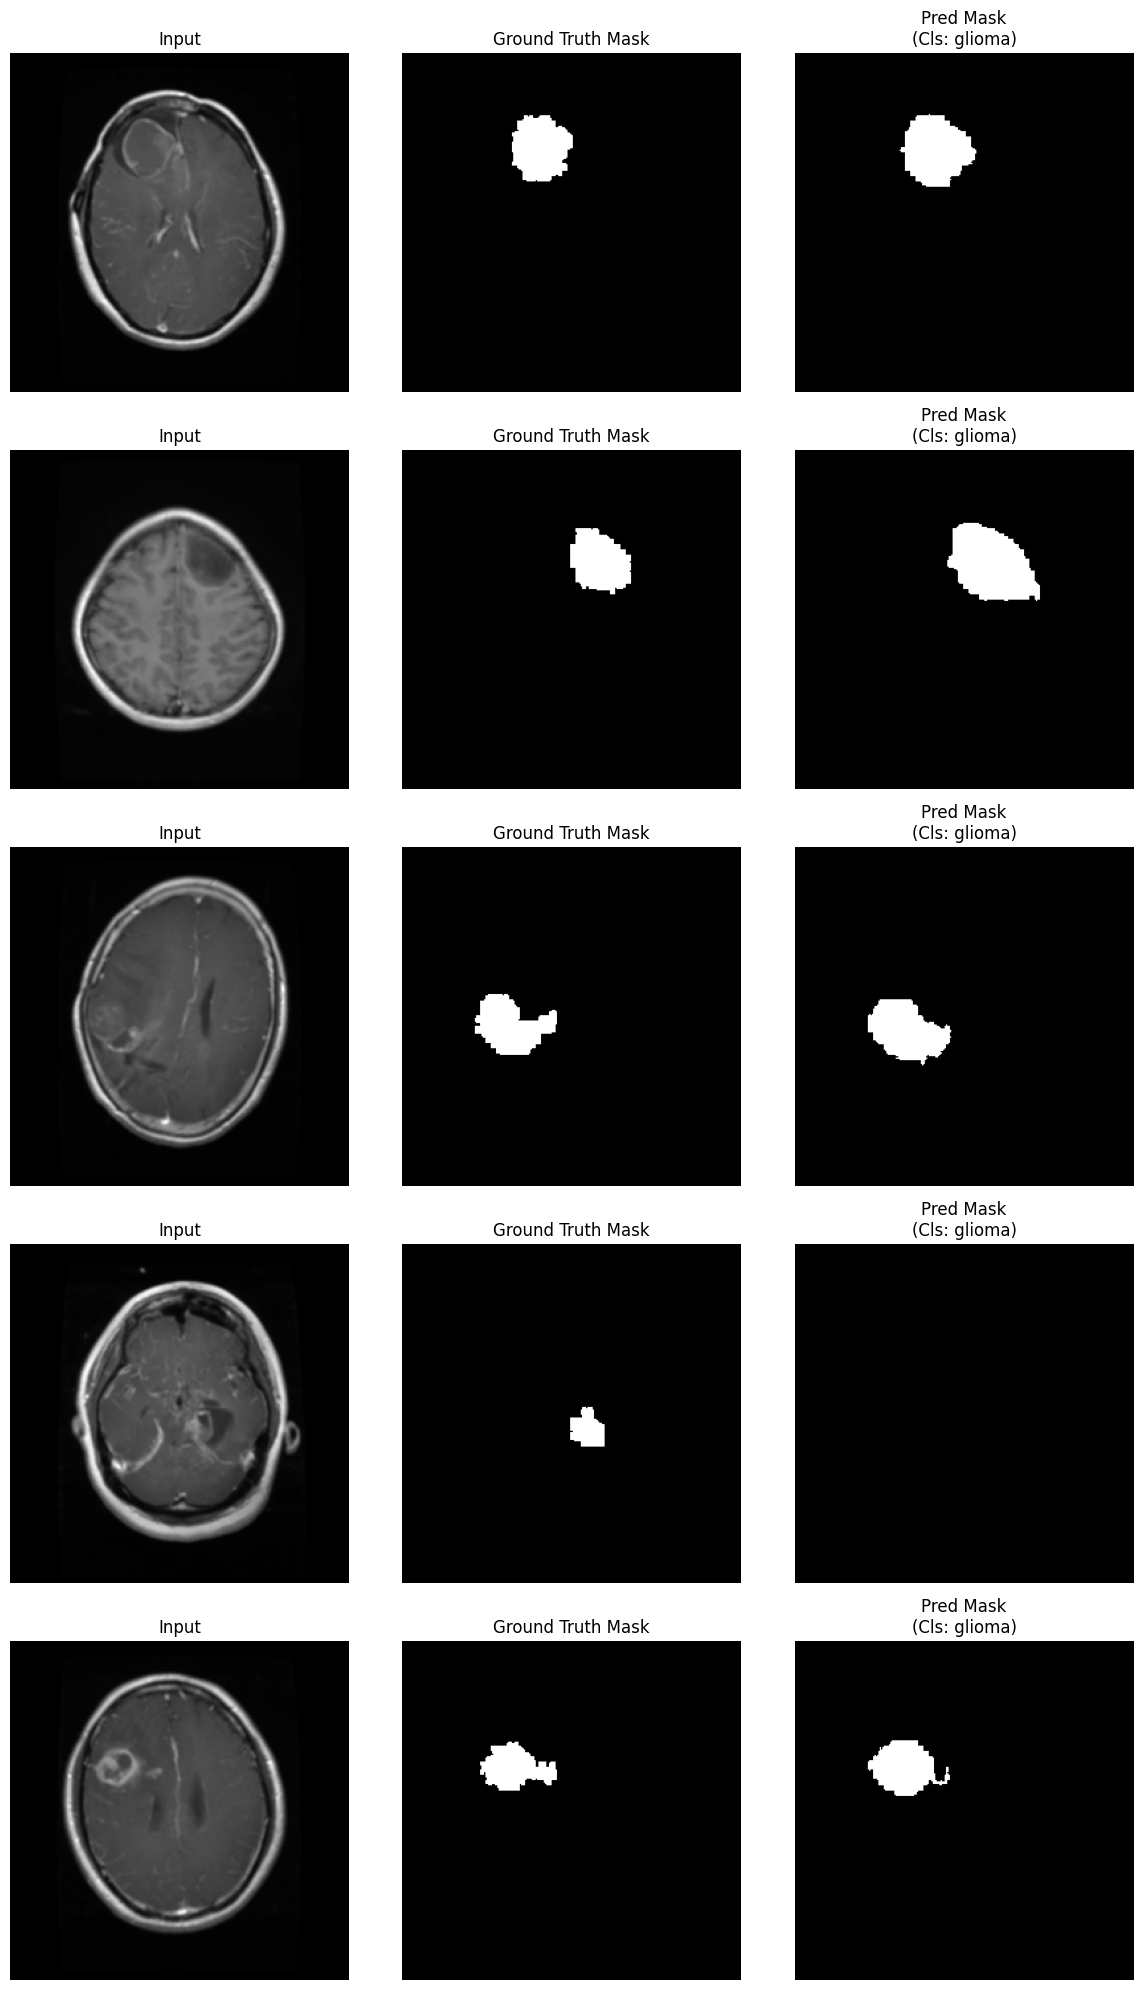

In [ ]:
# Joint Model
joint_model = JointUNet().to(device)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for Joint Model")
    joint_model = nn.DataParallel(joint_model)
joint_optimizer = optim.Adam(joint_model.parameters(), lr=LEARNING_RATE)
if os.path.exists(CHECKPOINT_PATH_JOINT):
    load_checkpoint(CHECKPOINT_PATH_JOINT, joint_model)
print("Training Joint Model")
train_model(
    joint_model, seg_train_dataloader, cls_train_dataloader,
    seg_val_dataloader, cls_val_dataloader,
    seg_criterion, cls_criterion, joint_optimizer,
    NUM_EPOCHS, device,
    model_type="joint",
    checkpoint_path=CHECKPOINT_PATH_JOINT,
    patience=5           
)
print("Visualizing Joint Model")
visualize_predictions(joint_model, seg_val_dataloader, "joint", device, n_images=5) 


Segmentation Metrics:
Dice: 0.7387, mIoU: 0.8128, Pixel Acc: 0.9887

Classification Report:
               precision    recall  f1-score   support

      glioma       0.91      0.98      0.95       254
  meningioma       0.98      0.86      0.92       306
    no_tumor       0.97      0.99      0.98       140
   pituitary       0.94      0.98      0.96       300

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000

Overall Classification Accuracy: 0.9470


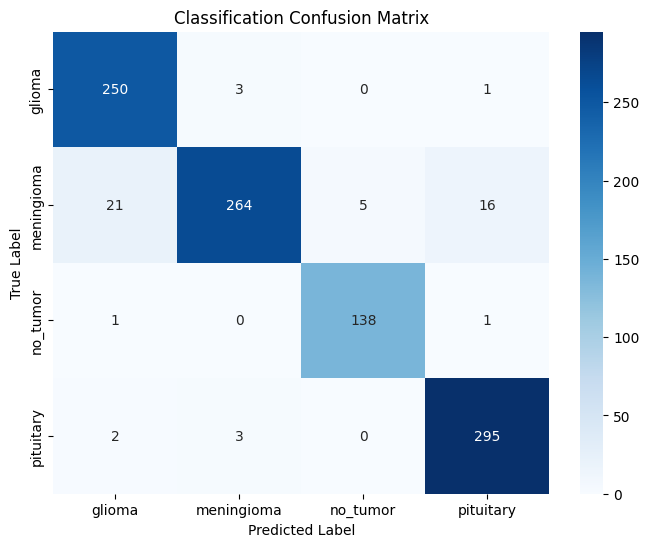

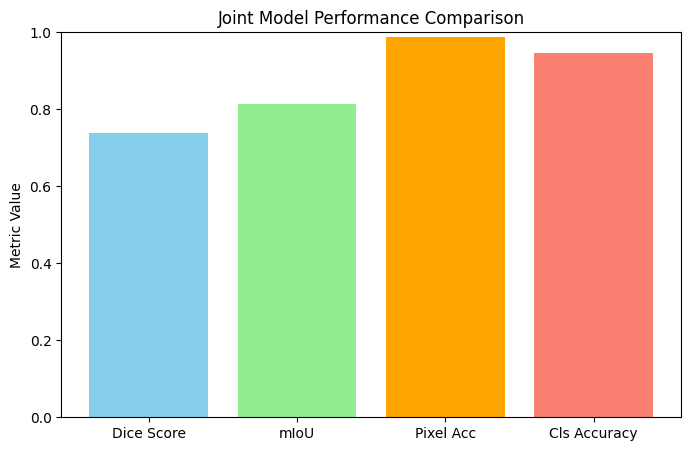

In [87]:
def evaluate_joint_model_fixed(model, seg_dataloader, cls_dataloader, device):
    model.eval()
    idx_to_class = cls_val_dataset.idx_to_class

    # ---------- Segmentation ----------
    all_seg_preds = []
    all_seg_targets = []
    with torch.no_grad():
        for images, masks in seg_dataloader:
            images, masks = images.to(device), masks.to(device)
            seg_logits, _ = model(images)
            seg_preds = (torch.sigmoid(seg_logits) > 0.5).float()
            all_seg_preds.append(seg_preds.cpu())
            all_seg_targets.append(masks.cpu())

    all_seg_preds = torch.cat(all_seg_preds, dim=0)
    all_seg_targets = torch.cat(all_seg_targets, dim=0)

    seg_dice = dice_metric(all_seg_preds, all_seg_targets).item()
    seg_miou = miou_metric(all_seg_preds, all_seg_targets)
    seg_pixel_acc = pixel_accuracy(all_seg_preds, all_seg_targets)
    print(f"Segmentation Metrics:\nDice: {seg_dice:.4f}, mIoU: {seg_miou:.4f}, Pixel Acc: {seg_pixel_acc:.4f}")

    # ---------- Classification ----------
    all_cls_preds = []
    all_cls_labels = []
    with torch.no_grad():
        for images, cls_names in cls_dataloader:
            images = images.to(device)
            labels = torch.tensor([cls_val_dataset.class_to_idx[name] for name in cls_names], dtype=torch.long).to(device)
            _, cls_logits = model(images)
            _, preds = torch.max(cls_logits, 1)
            all_cls_preds.extend(preds.cpu().numpy())
            all_cls_labels.extend(labels.cpu().numpy())

    report = classification_report(all_cls_labels, all_cls_preds,
                                   target_names=[idx_to_class[i] for i in range(len(idx_to_class))],
                                   zero_division=0)
    print("\nClassification Report:\n", report)

    overall_acc = np.mean(np.array(all_cls_preds) == np.array(all_cls_labels))
    print(f"Overall Classification Accuracy: {overall_acc:.4f}")

    cm = confusion_matrix(all_cls_labels, all_cls_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=[idx_to_class[i] for i in range(len(idx_to_class))],
                yticklabels=[idx_to_class[i] for i in range(len(idx_to_class))], cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Classification Confusion Matrix")
    plt.show()

    # ---------- Combined Metrics Plot ----------
    metrics = {
        "Dice Score": seg_dice,
        "mIoU": seg_miou,
        "Pixel Acc": seg_pixel_acc,
        "Cls Accuracy": overall_acc
    }

    plt.figure(figsize=(8,5))
    plt.bar(metrics.keys(), metrics.values(), color=["skyblue", "lightgreen", "orange", "salmon"])
    plt.ylim(0, 1)
    plt.title("Joint Model Performance Comparison")
    plt.ylabel("Metric Value")
    plt.show()


# Call the fixed evaluation
evaluate_joint_model_fixed(joint_model, seg_val_dataloader, cls_val_dataloader, device)


In [ ]:
# def joint_report(model, seg_dataloader, cls_dataloader, device, class_names):
#     print("\n=== Joint Model Evaluation ===")
#     segmentation_report(model, seg_dataloader, device)
#     classification_report_fn(model, cls_dataloader, device, class_names)


In [ ]:
# # === Separate vs Joint: Post-hoc Evaluation & Analysis ===
# import torch, time
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# @torch.no_grad()
# def eval_seg_model(model, loader, device):
#     model.eval()
#     total_dice, total_miou, total_pix = 0.0, 0.0, 0.0
#     n = 0
#     for images, masks in loader:
#         images, masks = images.to(device), masks.to(device)
#         logits = model(images)
#         total_dice += dice_metric(logits, masks)
#         total_miou += miou_metric(logits, masks)
#         total_pix  += pixel_accuracy(logits, masks)
#         n += 1
#     return {
#         "Dice": total_dice / max(n, 1),
#         "mIoU": total_miou / max(n, 1),
#         "PixelAcc": total_pix / max(n, 1),
#     }

# @torch.no_grad()
# def eval_cls_model(model, loader, device):
#     model.eval()
#     correct, total = 0, 0
#     total_prec, total_rec, total_f1 = 0.0, 0.0, 0.0
#     n = 0
#     for images, cls_names in loader:
#         images = images.to(device)
#         labels = torch.tensor([cls_train_dataset.class_to_idx[name] for name in cls_names],
#                               dtype=torch.long, device=device)
#         logits = model(images)
#         preds = torch.argmax(logits, dim=1)
#         correct += (preds == labels).sum().item()
#         total   += labels.size(0)
#         prec, rec, f1 = precision_recall_f1(logits, labels)  # assumes macro inside
#         total_prec += prec; total_rec += rec; total_f1 += f1
#         n += 1
#     return {
#         "ClsAcc": correct / max(total, 1),
#         "Precision": total_prec / max(n, 1),
#         "Recall":    total_rec  / max(n, 1),
#         "F1":        total_f1   / max(n, 1),
#     }

# @torch.no_grad()
# def eval_joint_model(joint_model, seg_loader, cls_loader, device):
#     joint_model.eval()
#     # seg head
#     sd, sm, sp = 0.0, 0.0, 0.0; ns = 0
#     for images, masks in seg_loader:
#         images, masks = images.to(device), masks.to(device)
#         seg_logits, _ = joint_model(images)
#         sd += dice_metric(seg_logits, masks)
#         sm += miou_metric(seg_logits, masks)
#         sp += pixel_accuracy(seg_logits, masks)
#         ns += 1
#     seg_metrics = {
#         "Dice": sd / max(ns, 1),
#         "mIoU": sm / max(ns, 1),
#         "PixelAcc": sp / max(ns, 1),
#     }
#     # cls head
#     cc, tot = 0, 0; tp, tr, tf = 0.0, 0.0, 0.0; nc = 0
#     for images, cls_names in cls_loader:
#         images = images.to(device)
#         labels = torch.tensor([cls_train_dataset.class_to_idx[name] for name in cls_names],
#                               dtype=torch.long, device=device)
#         _, cls_logits = joint_model(images)
#         preds = torch.argmax(cls_logits, dim=1)
#         cc += (preds == labels).sum().item()
#         tot += labels.size(0)
#         prec, rec, f1 = precision_recall_f1(cls_logits, labels)
#         tp += prec; tr += rec; tf += f1; nc += 1
#     cls_metrics = {
#         "ClsAcc": cc / max(tot, 1),
#         "Precision": tp / max(nc, 1),
#         "Recall":    tr / max(nc, 1),
#         "F1":        tf / max(nc, 1),
#     }
#     return seg_metrics, cls_metrics

# # ---- Run evaluations (uses already-trained models & your existing val loaders) ----
# seg_sep = eval_seg_model(seg_model, seg_val_dataloader, device)
# cls_sep = eval_cls_model(cls_model, cls_val_dataloader, device)
# joint_seg, joint_cls = eval_joint_model(joint_model, seg_val_dataloader, cls_val_dataloader, device)

# # ---- Build a tidy comparison table ----
# rows = []
# rows.append({"Model":"Separate-Seg",   **seg_sep, "ClsAcc":np.nan, "Precision":np.nan, "Recall":np.nan, "F1":np.nan})
# rows.append({"Model":"Joint-SegHead",  **joint_seg, "ClsAcc":np.nan, "Precision":np.nan, "Recall":np.nan, "F1":np.nan})
# rows.append({"Model":"Separate-Cls",   "Dice":np.nan, "mIoU":np.nan, "PixelAcc":np.nan, **cls_sep})
# rows.append({"Model":"Joint-ClsHead",  "Dice":np.nan, "mIoU":np.nan, "PixelAcc":np.nan, **joint_cls})

# df = pd.DataFrame(rows)[[
#     "Model", "Dice", "mIoU", "PixelAcc", "ClsAcc", "Precision", "Recall", "F1"
# ]]

# display(df)

# # ---- Delta analysis (Joint minus Separate) ----
# def delta(a, b):
#     if np.isnan(a) or np.isnan(b): return np.nan
#     return a - b

# seg_dice_delta = delta(joint_seg["Dice"], seg_sep["Dice"])
# seg_miou_delta = delta(joint_seg["mIoU"], seg_sep["mIoU"])
# seg_pix_delta  = delta(joint_seg["PixelAcc"], seg_sep["PixelAcc"])

# cls_acc_delta  = delta(joint_cls["ClsAcc"], cls_sep["ClsAcc"])
# cls_p_delta    = delta(joint_cls["Precision"], cls_sep["Precision"])
# cls_r_delta    = delta(joint_cls["Recall"],    cls_sep["Recall"])
# cls_f1_delta   = delta(joint_cls["F1"],        cls_sep["F1"])

# print("\n=== Joint vs Separate: Metric Deltas (Joint - Separate) ===")
# print(f"Seg: ΔDice={seg_dice_delta:.4f}, ΔmIoU={seg_miou_delta:.4f}, ΔPixelAcc={seg_pix_delta:.4f}")
# print(f"Cls: ΔAcc={cls_acc_delta:.4f}, ΔPrecision={cls_p_delta:.4f}, ΔRecall={cls_r_delta:.4f}, ΔF1={cls_f1_delta:.4f}")

# # ---- Short automatic interpretation ----
# def verdict(delta, name):
#     if np.isnan(delta): return f"{name}: N/A"
#     if delta >  0.005: return f"{name}: Joint clearly better (+{delta:.3f})."
#     if delta < -0.005: return f"{name}: Separate clearly better ({delta:.3f})."
#     return f"{name}: Essentially tied ({delta:.3f})."

# print("\n=== Quick Interpretation ===")
# print(verdict(seg_dice_delta, "Seg Dice"))
# print(verdict(seg_miou_delta, "Seg mIoU"))
# print(verdict(seg_pix_delta,  "Seg PixelAcc"))
# print(verdict(cls_acc_delta,  "Cls Acc"))
# print(verdict(cls_p_delta,    "Cls Precision"))
# print(verdict(cls_r_delta,    "Cls Recall"))
# print(verdict(cls_f1_delta,   "Cls F1"))

# # ---- (Optional) Save to CSV for your report ----
# csv_path = "/kaggle/working/separate_vs_joint_metrics.csv"
# df.to_csv(csv_path, index=False)
# print(f"\nSaved summary to: {csv_path}")

# # ---- (Optional) Simple bar charts per task (1 metric each) ----
# # Note: keep charts minimal for Kaggle reports.
# plt.figure(figsize=(6,4))
# plt.bar(["Separate-Seg","Joint-SegHead"], [seg_sep["Dice"], joint_seg["Dice"]])
# plt.title("Segmentation Dice: Separate vs Joint")
# plt.ylabel("Dice")
# plt.show()

# plt.figure(figsize=(6,4))
# plt.bar(["Separate-Cls","Joint-ClsHead"], [cls_sep["F1"], joint_cls["F1"]])
# plt.title("Classification F1: Separate vs Joint")
# plt.ylabel("F1")
# plt.show()


In [ ]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_confusion_matrix(model, dataloader, device, class_names=None, save_path=None):
#     """
#     Plot confusion matrix for a PyTorch classification model
    
#     Args:
#         model: Trained PyTorch model
#         dataloader: DataLoader for evaluation data
#         device: Device (cuda/cpu)
#         class_names: List of class names for labels (optional)
#         save_path: Path to save the confusion matrix plot (optional)
#     """
#     model.eval()
#     true_labels = []
#     pred_labels = []
    
#     with torch.no_grad():
#         for inputs, labels in dataloader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
            
#             # Convert to numpy and append
#             true_labels.extend(labels.cpu().numpy())
#             pred_labels.extend(preds.cpu().numpy())
    
#     # Create confusion matrix
#     cm = confusion_matrix(true_labels, pred_labels)
    
#     # Plot confusion matrix
#     fig, ax = plt.subplots(figsize=(8, 6))
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
#     disp.plot(ax=ax, cmap=plt.cm.Blues)
#     plt.title('Confusion Matrix')
#     plt.tight_layout()
    
#     if save_path:
#         plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
#     plt.show()
    
#     # Print additional metrics
#     print(f"\nConfusion Matrix:")
#     print(cm)
    
#     # Calculate per-class accuracy
#     class_accuracy = cm.diagonal() / cm.sum(axis=1)
#     print(f"\nPer-class accuracy:")
#     for i, acc in enumerate(class_accuracy):
#         class_name = class_names[i] if class_names else f"Class {i}"
#         print(f"{class_name}: {acc:.4f}")
    
#     # Overall accuracy
#     overall_accuracy = np.trace(cm) / np.sum(cm)
#     print(f"\nOverall accuracy: {overall_accuracy:.4f}")
    
#     return cm


# # Add confusion matrix visualization
# print("Generating Confusion Matrix")
# # Define class names if you have them (adjust according to your classes)
# class_names =  ['glioma', 'meningioma', 'no_tumor', 'pituitary']  

# # Plot confusion matrix
# confusion_mat = plot_confusion_matrix(
#     cls_model, 
#     cls_val_dataloader, 
#     device, 
#     class_names=class_names,
# )